# Debug

## Jax

++++++++++++++++++++

Text(0, 0.5, 'error')

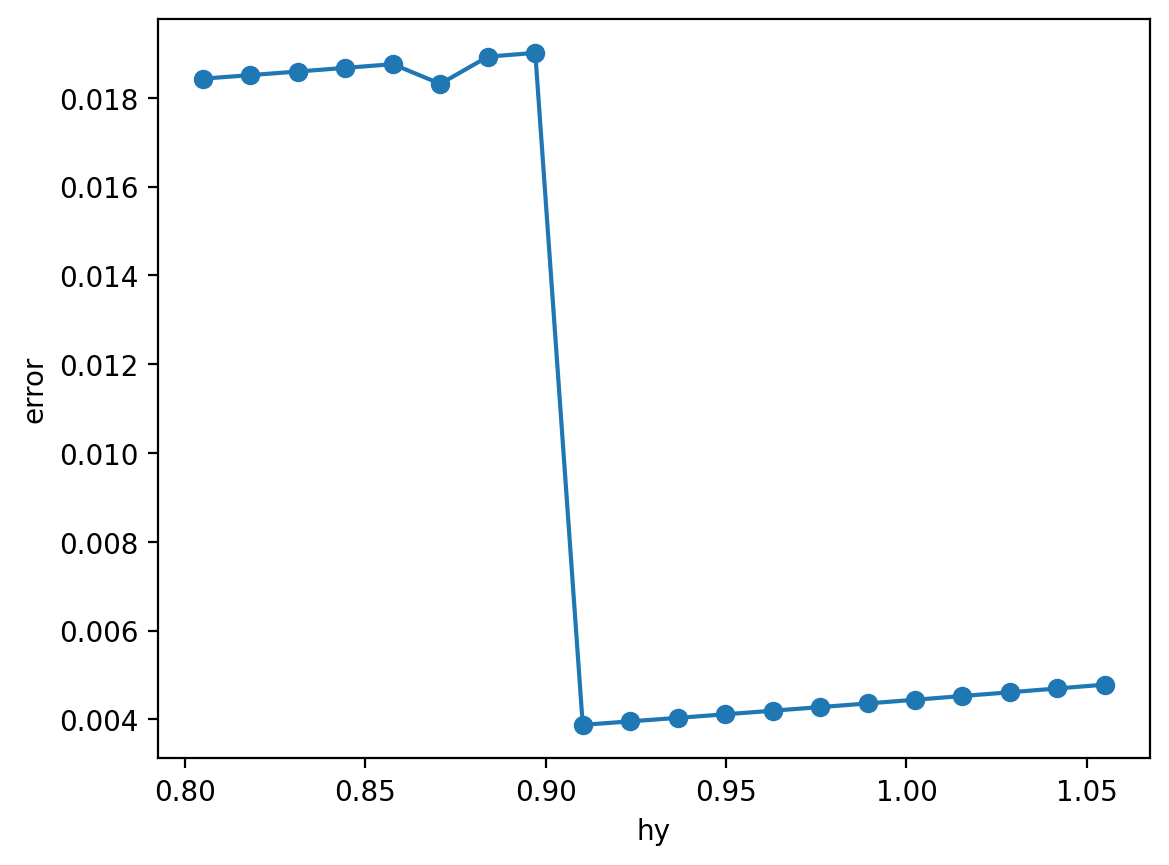

In [5]:
import numpy as np
from qiskit.quantum_info import Statevector
from spin import Nearest_Neighbour_1d
from trotter import pf
import matplotlib.pyplot as plt

hy_list = np.linspace(0.805, 1.055, 20)

n, t = 10, 5*2
r = 100

init_state = Statevector.from_label('10'* (n//2)+'1'*(n%2))
err_hy_list, one_err_hy_list  = [], []

for hy in hy_list:
    print('+', end='')
    QIMF = Nearest_Neighbour_1d(n, hx=0.8001, hy=hy, Jx=1, pbc=False)
    # appro_U, exact_U = pf(QIMF.ham_xyz, t, r, order=2, return_exact=True)
    one_appro_U, one_exact_U = pf(QIMF.ham_xyz, t/r, 1, order=2, return_exact=True, use_jax=False)
    # print(np.linalg.norm(one_exact_U - expH(sum(QIMF.ham_xyz), t/r, use_jax=True), ord=2))
    # one_appro_U, one_exact_U = pf(QIMF.ham_xyz, t/r, 1, order=2, return_exact=True)
    # err_hy_list.append(np.linalg.norm((appro_U - exact_U) @ init_state.data, ord=2)*r)
    one_err_hy_list.append(np.linalg.norm((one_appro_U - one_exact_U) @ init_state.data, ord=2))


fig, ax = plt.subplots()
# ax.plot(hy_list, err_hy_list, '-o')
ax.plot(hy_list, one_err_hy_list, '-o')
ax.set_xlabel('hy')
ax.set_ylabel('error')
# fig.savefig(f'{fig_dir}/error_hy_n={n}_t={t}_r={r}_jax=True.pdf', bbox_inches='tight')

## Partial trace and entropy

Hamiltonian list: 
 [SparsePauliOp(['IIIIIIIIXX', 'IIIIIIIXXI', 'IIIIIIXXII', 'IIIIIXXIII', 'IIIIXXIIII', 'IIIXXIIIII', 'IIXXIIIIII', 'IXXIIIIIII', 'XXIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[1.    +0.j, 1.    +0.j, 1.    +0.j, 1.    +0.j, 1.    +0.j, 1.    +0.j,
 1.    +0.j, 1.    +0.j, 1.    +0.j, 0.8001+0.j, 0.8001+0.j, 0.8001+0.j,
 0.8001+0.j, 0.8001+0.j, 0.8001+0.j, 0.8001+0.j, 0.8001+0.j, 0.8001+0.j,
 0.8001+0.j]), SparsePauliOp(['IIIIIIIIIY', 'IIIIIIIIYI', 'IIIIIIIYII', 'IIIIIIYIII', 'IIIIIYIIII', 'IIIIYIIIII', 'IIIYIIIIII', 'IIYIIIIIII', 'IYIIIIIIII', 'YIIIIIIIII'],
              coeffs=[0.8908+0.j, 0.8908+0.j, 0.8908+0.j, 0.8908+0.j, 0.8908+0.j, 0.8908+0.j,
 0.8908+0.j, 0.8908+0.j, 0.8908+0.j, 0.8908+0.j])]
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++not valid density matrix
61 False (1.0000101186639283-1.7070695810923561e-19j) 

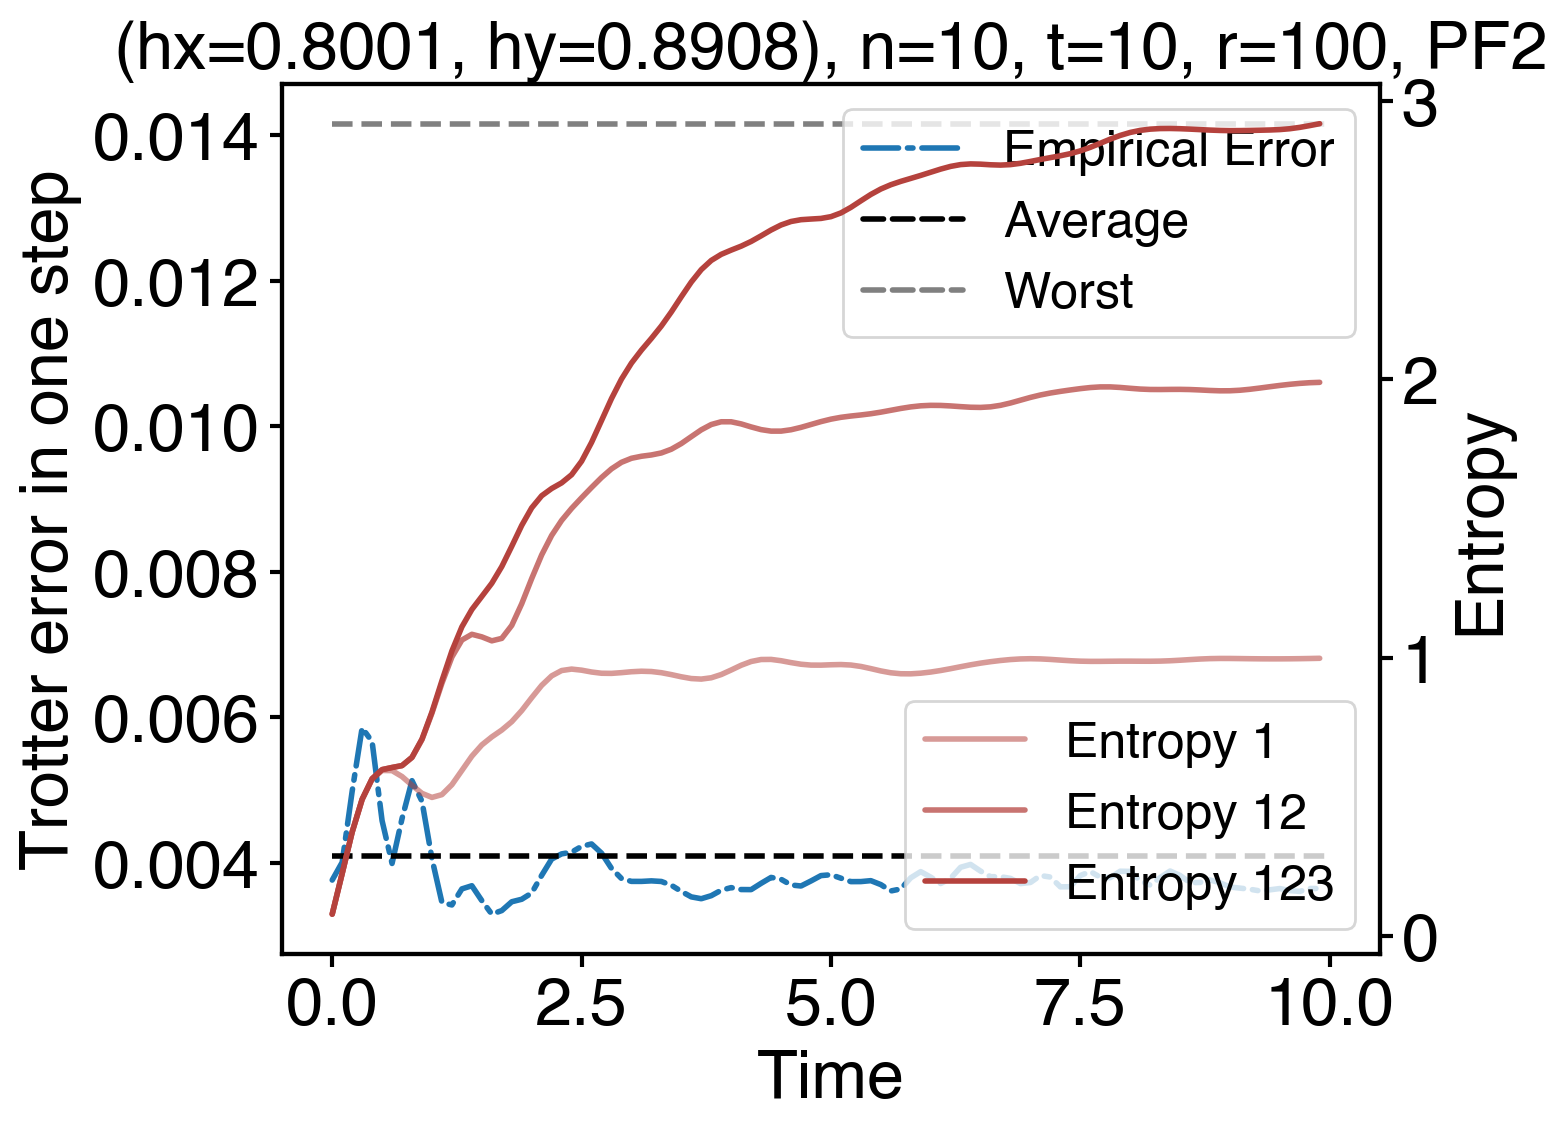

In [9]:
from qiskit.quantum_info import DensityMatrix, partial_trace, entropy
from bounds import tight_bound

n, t = 10, 5*2
r = 100
typical = True

if typical:
    QIMF = Nearest_Neighbour_1d(n, hx=0.8001, hy=0.8908, Jx=1, pbc=False)
    # QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045,Jx=1, pbc=False)
else:
    QIMF = Nearest_Neighbour_1d(n, hx=0.8, hy=0.9, Jx=1, pbc=False)

H_list = QIMF.ham_xyz
# H_list = [h for h in QIMF.ham_par]
print('Hamiltonian list: \n', H_list)

appro_U, exact_U = pf(H_list, t/r, 1, order=2, return_exact=True, use_jax=True)

emp_err_list, entropy_list, purity_list = [], [], []

init_state = Statevector.from_label('10'* (n//2)+'1'*(n%2))
current_state = init_state.data  

for d in range(r):
    print('+', end='')
    # U_exact = expH(QIMF.ham, t)
    ideal_state = exact_U @ current_state   
    current_state = appro_U @ current_state
    #finl_state = U_exact @ init_state
    rdm1 = partial_trace(DensityMatrix(Statevector(current_state)), [0])
    rdm2 = partial_trace(DensityMatrix(Statevector(current_state)), [0,1])
    rdm3 = partial_trace(DensityMatrix(Statevector(current_state)), [0,1,2])
    ## qiskit partial trace is not a valid density matrix within the tolerance for entropy
    # purity_list.append(rdm.purity())
    # print(rdm1)
    if rdm1.is_valid() and rdm2.is_valid() and rdm3.is_valid():
        pass
    else:
        print('not valid density matrix')
        print(d, rdm1.is_valid(), np.trace(rdm1), rdm1.atol, rdm1.rtol)
        rdm1, rdm2, rdm3 = DensityMatrix(rdm1.data/np.trace(rdm1)), DensityMatrix(rdm2.data/np.trace(rdm2)), DensityMatrix(rdm3.data/np.trace(rdm3))
    # print(isinstance(rdm1, (Statevector, DensityMatrix)))
    entropy_list.append([entropy(rdm1), entropy(rdm2), entropy(rdm3)])
    emp_err_list.append(np.linalg.norm(current_state - ideal_state))
    
fig, ax = plt.subplots()
ax.plot(np.array(range(r))*t/r, emp_err_list, '-.', label=f'Empirical Error', c="tab:blue")
ax.hlines(tight_bound(H_list, 2, t, r, type='fro')/r, 0, t, colors='k', linestyles='dashed', label='Average')
ax.hlines(tight_bound(H_list, 2, t, r)/r, 0, t, colors='grey', linestyles='dashed', label='Worst')
    
ax.set_xlabel('Time')
ax.set_ylabel('Trotter error in one step')
ax.set_title(f'(hx={QIMF.hx}, hy={QIMF.hy}), n={n}, t={t}, r={r}, PF2')
# twin y axis for empirical error
ax2 = ax.twinx()
ax2.set_ylabel('Entropy')
ax2.plot(np.array(range(r))*t/r, np.array(entropy_list)[:, 0], '-', label=f'Entropy 1', c="#b5423d88")
ax2.plot(np.array(range(r))*t/r, np.array(entropy_list)[:, 1], '-', label=f'Entropy 12', c="#b5423dBB")
ax2.plot(np.array(range(r))*t/r, np.array(entropy_list)[:, 2], '-', label=f'Entropy 123', c="#b5423dFF")
ax.legend(); 
ax2.legend()